In [13]:
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, RandomSampler
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import matplotlib.pyplot as plt
from PIL import Image

In [14]:
# Checking versions of the packages
print(f"numpy version: {np.__version__}")
print(f"torch version: {torch.__version__}")
print(f"Pillow (PIL) version: {Image.__version__}")

numpy version: 2.0.2
torch version: 2.5.1+cu124
Pillow (PIL) version: 11.0.0


In [15]:
# Hyperparameters
DEVICE = torch.device('cpu')  # Set device to CPU since we want to run without CUDA
NUM_TIMESTEPS = 10
BATCH_SIZE = 2
NUM_EPOCHS = 1
LEARNING_RATE = 1e-4
IMAGE_SIZE = 128
NUM_SAMPLES = 100

In [16]:
# Data loading parameters
TRANSFORM = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])

In [17]:
def load_data():
    mnist_dataset = MNIST(root='./', train=True, download=True, transform=TRANSFORM)
    sampler = RandomSampler(mnist_dataset, num_samples=NUM_SAMPLES)
    data_loader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4)
    return data_loader

In [18]:
def initialize_model():
    model = Unet(dim=64, dim_mults=(1, 2, 4, 8)).to(DEVICE)
    diffusion = GaussianDiffusion(model, image_size=IMAGE_SIZE, timesteps=NUM_TIMESTEPS).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    return model, diffusion, optimizer


In [19]:
def train(model, diffusion, optimizer, data_loader):
    for epoch in range(NUM_EPOCHS):
        for images, _ in data_loader:
            images = images.to(DEVICE)
            optimizer.zero_grad()
            loss = diffusion(images)
            loss.backward()
            optimizer.step()
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')


In [20]:
def generate_and_plot_images(diffusion):
    with torch.no_grad():
        sample_images = diffusion.sample(2)
    sample_images = (sample_images + 1) / 2  # Rescale to [0, 1]

    plt.figure(figsize=(10, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.imshow(sample_images[i].permute(1, 2, 0).cpu().numpy())  # Change to (H, W, C)
        plt.axis('off')
    plt.show()


In [21]:
# Display the original images
def show_images(images, title='Original Images'):
    """Utility function to display images."""
    num_images = images.shape[0]
    plt.figure(figsize=(num_images * 3, 3))  
    for i in range(num_images):
        img = (images[i][0].cpu().numpy() + 1) / 2 
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [22]:
def create_denoising_gif(images, diffusion, index):
    original_image = images[index:index+1]  # Shape: (1, C, H, W)
    frames = []

    noise_images = original_image.clone()
    for t in range(1, NUM_TIMESTEPS + 1):
        noise_factor = torch.randn_like(noise_images) * (t / NUM_TIMESTEPS)
        noisy_images = torch.clamp(noise_images + noise_factor, -1, 1)
        img = (noisy_images[0][0].cpu().numpy() + 1) / 2
        frames.append(Image.fromarray((img * 255).astype(np.uint8), mode='L'))

    for t in reversed(range(NUM_TIMESTEPS)):
        with torch.no_grad():
            denoised_images, _ = diffusion.p_sample(noisy_images, t)
            img = (denoised_images[0][0].cpu().numpy() + 1) / 2
            frames.append(Image.fromarray((img * 255).astype(np.uint8), mode='L'))
            noisy_images = denoised_images.clone()

    output_gif_path = f'noising_progression_image_{index + 1}.gif'
    frames[0].save(output_gif_path, save_all=True, append_images=frames[1:], duration=100, loop=0)
    print(f'GIF saved at {output_gif_path}')


In [23]:
def create_noise_interpolation_gif(images, index):
    original_image = images[index:index + 1]
    frames = []
    noise_images = torch.randn_like(original_image)

    for t in range(1, NUM_TIMESTEPS + 1):
        interpolation_factor = t / NUM_TIMESTEPS
        interpolated_image = noise_images * (1 - interpolation_factor) + original_image * interpolation_factor
        img = (interpolated_image[0][0].cpu().numpy() + 1) / 2
        frames.append(Image.fromarray((img * 255).astype(np.uint8), mode='L'))

    output_gif_path = f'gaussian_noise_to_mnist_image_{index + 1}.gif'
    frames[0].save(output_gif_path, save_all=True, append_images=frames[1:], duration=100, loop=0)
    print(f'GIF saved at {output_gif_path}')


Epoch [1/1], Loss: 2.7226
Epoch [1/1], Loss: 0.9699
Epoch [1/1], Loss: 0.5963
Epoch [1/1], Loss: 1.3507
Epoch [1/1], Loss: 0.2538
Epoch [1/1], Loss: 0.5830
Epoch [1/1], Loss: 0.1864
Epoch [1/1], Loss: 0.9012
Epoch [1/1], Loss: 1.0091
Epoch [1/1], Loss: 0.4113
Epoch [1/1], Loss: 0.3158
Epoch [1/1], Loss: 0.6956
Epoch [1/1], Loss: 0.4718
Epoch [1/1], Loss: 0.0570
Epoch [1/1], Loss: 0.2505
Epoch [1/1], Loss: 0.3402
Epoch [1/1], Loss: 0.2629
Epoch [1/1], Loss: 0.3293
Epoch [1/1], Loss: 1.0894
Epoch [1/1], Loss: 0.0830
Epoch [1/1], Loss: 0.3157
Epoch [1/1], Loss: 0.7651
Epoch [1/1], Loss: 0.3854
Epoch [1/1], Loss: 0.0002
Epoch [1/1], Loss: 1.0987
Epoch [1/1], Loss: 0.1509
Epoch [1/1], Loss: 0.9443
Epoch [1/1], Loss: 0.2410
Epoch [1/1], Loss: 0.9412
Epoch [1/1], Loss: 0.2528
Epoch [1/1], Loss: 0.2859
Epoch [1/1], Loss: 0.4039
Epoch [1/1], Loss: 0.5395
Epoch [1/1], Loss: 0.1520
Epoch [1/1], Loss: 0.4163
Epoch [1/1], Loss: 0.8280
Epoch [1/1], Loss: 0.2552
Epoch [1/1], Loss: 0.6046
Epoch [1/1],

sampling loop time step: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


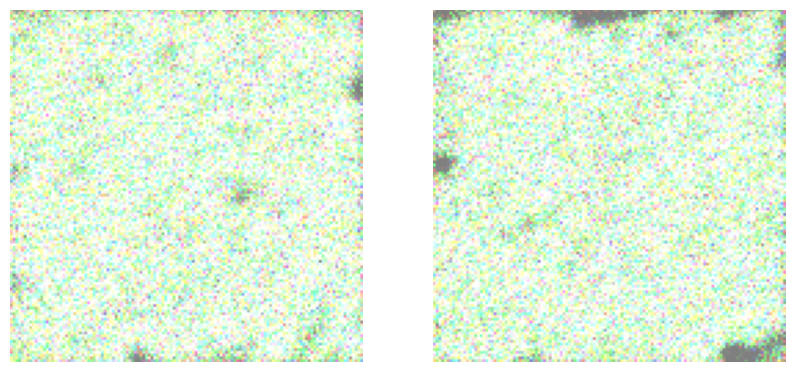

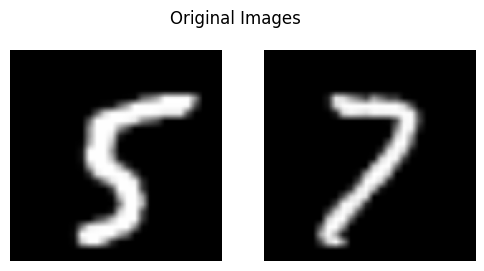

GIF saved at noising_progression_image_1.gif
GIF saved at gaussian_noise_to_mnist_image_1.gif
GIF saved at noising_progression_image_2.gif
GIF saved at gaussian_noise_to_mnist_image_2.gif


In [24]:
def main():
    data_loader = load_data()
    model, diffusion, optimizer = initialize_model()
    train(model, diffusion, optimizer, data_loader)

    generate_and_plot_images(diffusion)
    original_images = next(iter(data_loader))[0].to(DEVICE)
    show_images(original_images)

    # Create GIFs for each image in the batch
    for img_index in range(original_images.shape[0]):
        create_denoising_gif(original_images, diffusion, img_index)
        create_noise_interpolation_gif(original_images, img_index)


main()